In [3]:
pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 58.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.2 MB/s eta 0:00:00


In [4]:
#Data gathering and Exploration

import pandas as pd
import numpy as np
import yfinance as yf
import streamlit as st
import pickle
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.float_format', '{:.2f}'.format)

In [7]:
# Define the list of cryptocurrency tickers
cryptocurrencies = ['BTC-USD', 'ETH-USD', 'ADA-USD', 'XRP-USD', 'BNB-USD']

In [8]:
# Download historical data for the specified tickers within a custom date range
start_date = '2014-01-01'
end_date = datetime.datetime.now().strftime('%Y-%m-%d')
crypto_df = pd.DataFrame()
for ticker in cryptocurrencies:
    data = yf.download(ticker, start=start_date, end=end_date)
    data['currency'] = ticker
    crypto_df = pd.concat([crypto_df,data])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [9]:
# Drop any rows with missing data
crypto_df.dropna(inplace=True)

crypto_df.sort_values(by=['currency','Date'],ascending = True, inplace=True)

for lag in [1,7,14,21,30,60,120]:
    crypto_df[f'lag_{lag}'] = crypto_df.groupby('currency')['Close'].shift(lag)

crypto_df.index = pd.to_datetime(crypto_df.index)

In [10]:
# Extract Year, Month, and Day
crypto_df['year'] = crypto_df.index.year
crypto_df['month'] = crypto_df.index.month
crypto_df['day'] = crypto_df.index.day
crypto_df['quarter'] = crypto_df.index.quarter
crypto_df['weekday'] = crypto_df.index.weekday

crypto_df['is_weekend'] = (crypto_df.index.weekday >= 5).astype(int)
crypto_df['is_start_of_month'] = (crypto_df.index.day == 1).astype(int)
crypto_df['is_end_of_month'] = (crypto_df.index.is_month_end).astype(int)

for lag in [7,14,21,30,60,180]:
    crypto_df[f'rolling_{lag}'] = crypto_df.groupby('currency')['Close'].shift(lag).rolling(lag).mean()

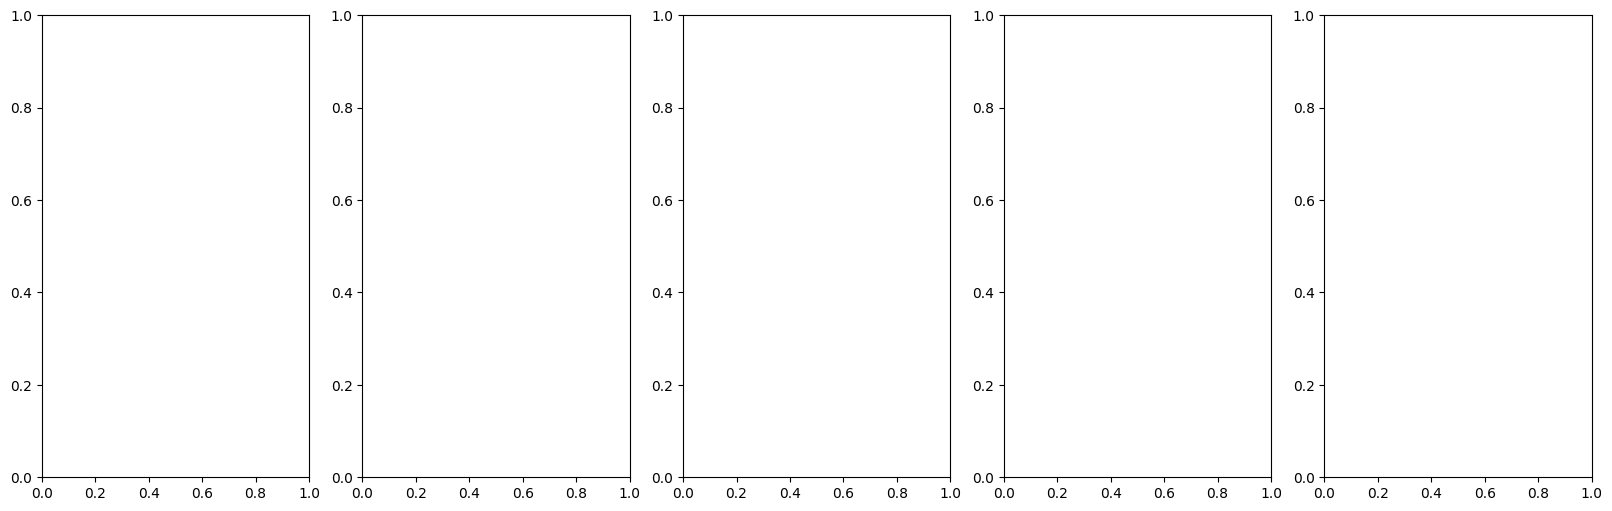

In [11]:
# Create subplots for each currency
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=False)

In [12]:
# Define custom colors for each currency
colors = {'BTC-USD': 'blue', 'ETH-USD': 'green', 'ADA-USD': 'orange', 'XRP-USD': 'purple', 'BNB-USD': 'red'}


In [13]:
# Iterate through each currency and create a boxplot
for i, currency in enumerate(crypto_df['currency'].unique()):
    sns.boxplot(y='Close', data=crypto_df[crypto_df['currency'] == currency], ax=axes[i], color=colors[currency])
    axes[i].set_title(currency)
    axes[i].set_xlabel('Closing Price')

In [14]:
# Set common y-axis label
fig.text(0.04, 0.5, 'Closing Price', va='center', rotation='vertical')

plt.show()

unique_currencies = crypto_df['currency'].unique()

In [15]:
# for currency in unique_currencies:
#     plt.figure(figsize=(12, 6))
#     subset_df = crypto_df[crypto_df['currency'] == currency]
#     plt.plot(subset_df.index, subset_df['Close'], label=currency,color=colors[currency])
#     plt.title(f"{currency} - Close Price")
#     plt.xlabel("Date")
#     plt.ylabel("Close Price")
#     plt.legend()
#     plt.show()

In [16]:
crypto_df.dropna(inplace=True)

from sklearn.preprocessing import LabelEncoder

# with open('encoder.pkl', 'wb') as file:
#     pickle.dump(le, file)

In [17]:
# Feature selection (assuming you want to predict 'Close' price)
X = crypto_df.drop(columns = ['Adj Close','Close']) # Features
y = crypto_df['Close']  # Target variable

le = LabelEncoder()
X['currency'] = le.fit_transform(X['currency'])

xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.2,random_state = 42)

Scaler = StandardScaler()
xtrain = Scaler.fit_transform(xtrain)
xtest = Scaler.transform(xtest)

In [18]:
# Initialize the models
rf_model = RandomForestRegressor(random_state=42)
gb_model = GradientBoostingRegressor(random_state=42)
xgb_model = xgb.XGBRegressor(random_state=42)
svr_model = SVR()
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)

In [19]:
# Train and evaluate each models
models = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
    "Support Vector Regression": svr_model,
    "Linear Regression": lr_model,
    "Decision Tree": dt_model
}

results_list = []

for name, model in models.items():
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    mse = mean_squared_error(ytest, y_pred)
    mae = mean_absolute_error(ytest, y_pred)
    r2 = r2_score(ytest, y_pred)

    results_list.append([name, mse, mae])

results_df = pd.DataFrame(results_list, columns=["Model", "MSE", "MAE"])

results_df = results_df.sort_values(by = 'MAE')
print(results_df)

X = Scaler.fit_transform(X)
lr_model = model.fit(X, y)

                       Model          MSE     MAE
4          Linear Regression     37298.53   54.72
0              Random Forest     86525.02   75.19
2                    XGBoost    114966.61   96.31
1          Gradient Boosting    103640.89   96.49
5              Decision Tree    172234.83  101.79
3  Support Vector Regression 185989283.20 5197.90


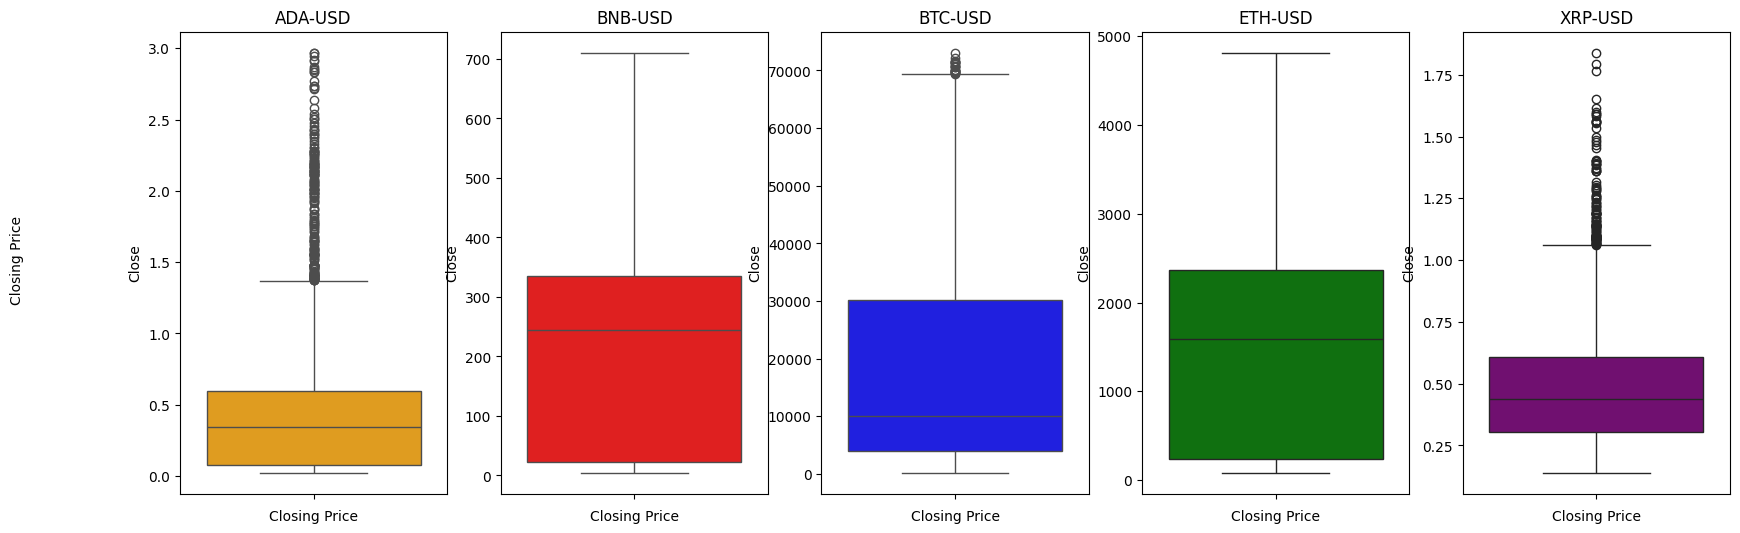

In [20]:
# Create subplots for each currency
fig, axes = plt.subplots(1, 5, figsize=(20, 6), sharey=False)

# Define custom colors for each currency
colors = {'BTC-USD': 'blue', 'ETH-USD': 'green', 'ADA-USD': 'orange', 'XRP-USD': 'purple', 'BNB-USD': 'red'}

# Iterate through each currency and create a boxplot
for i, currency in enumerate(crypto_df['currency'].unique()):
    sns.boxplot(y='Close', data=crypto_df[crypto_df['currency'] == currency], ax=axes[i], color=colors[currency])
    axes[i].set_title(currency)
    axes[i].set_xlabel('Closing Price')

# Set common y-axis label
fig.text(0.04, 0.5, 'Closing Price', va='center', rotation='vertical')

plt.show()


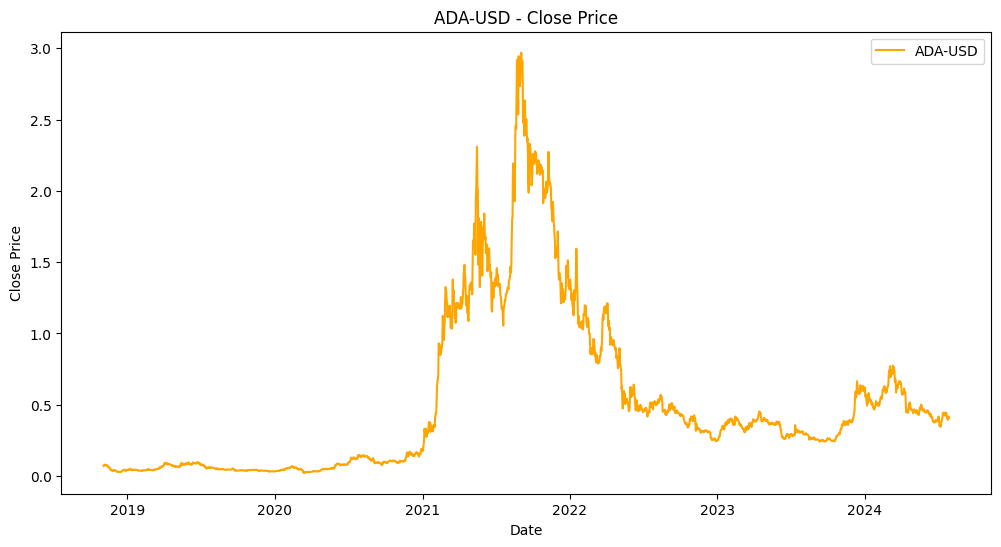

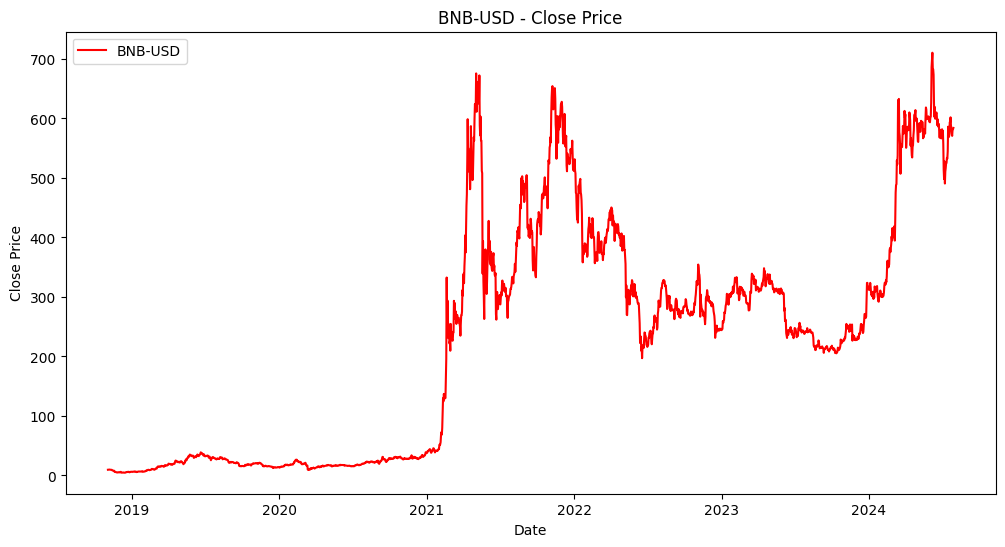

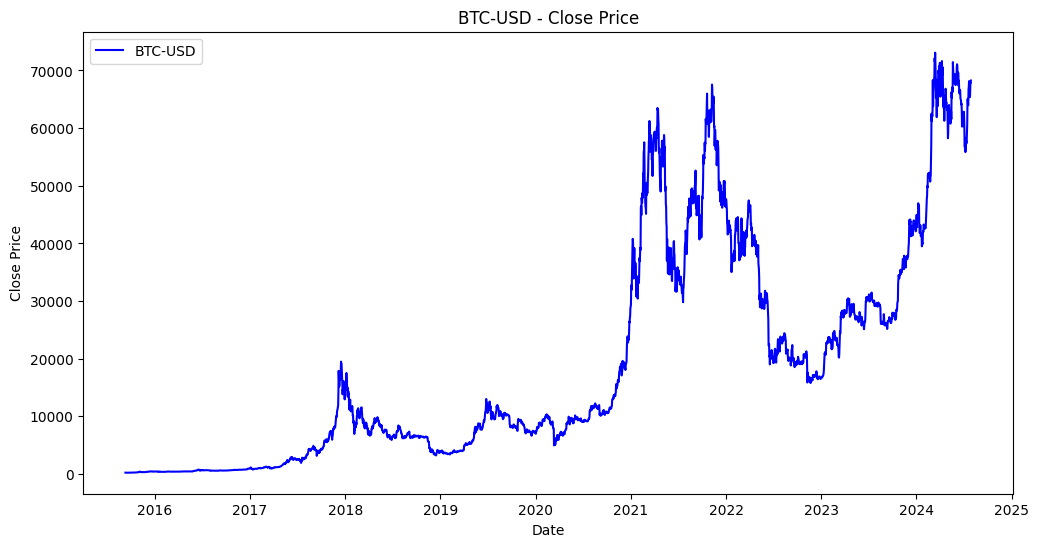

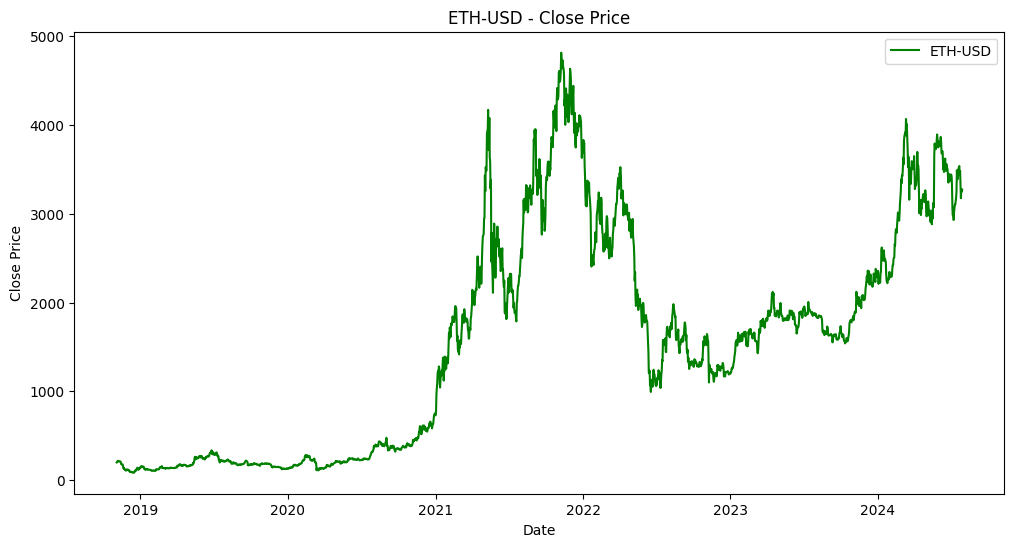

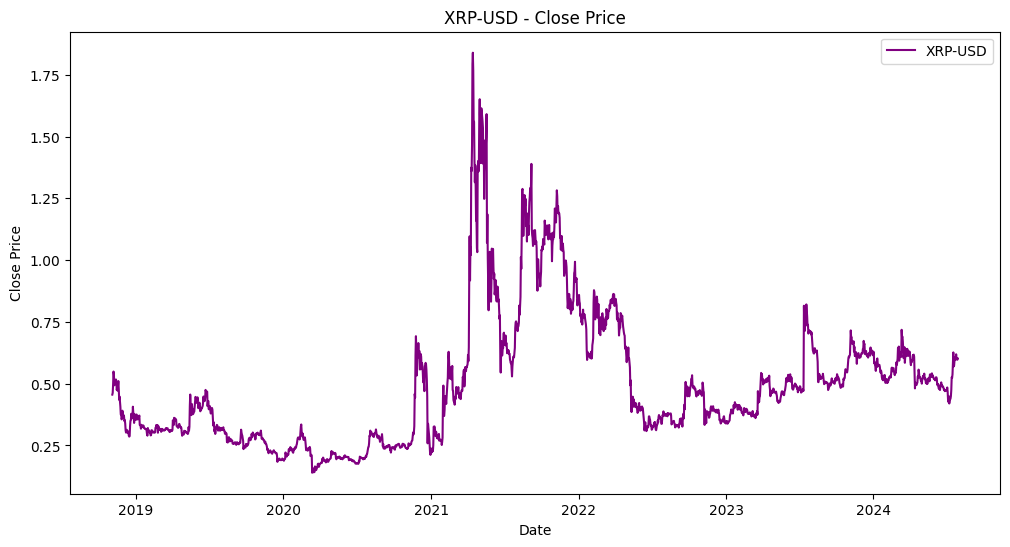

In [21]:
unique_currencies = crypto_df['currency'].unique()

for currency in unique_currencies:
    plt.figure(figsize=(12, 6))
    subset_df = crypto_df[crypto_df['currency'] == currency]
    plt.plot(subset_df.index, subset_df['Close'], label=currency,color=colors[currency])
    plt.title(f"{currency} - Close Price")
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.legend()
    plt.show()


In [22]:
crypto_df.dropna(inplace=True)

In [23]:
crypto_df.shape

(11624, 28)

In [24]:
from sklearn.preprocessing import LabelEncoder

In [25]:
le = LabelEncoder()
crypto_df['currency'] = le.fit_transform(crypto_df['currency'])

In [26]:
# Feature selection (assuming you want to predict 'Close' price)
X = crypto_df.drop(columns = ['Adj Close','Close']) # Features
y = crypto_df['Close']  # Target variable

In [27]:
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size = 0.25,random_state = 42)

In [28]:
Scaler = StandardScaler()
xtrain = Scaler.fit_transform(xtrain)
xtest = Scaler.transform(xtest)

In [29]:
# Initialize the models
rf_model = RandomForestRegressor()
gb_model = GradientBoostingRegressor()
xgb_model = xgb.XGBRegressor()
svr_model = SVR()
lr_model = LinearRegression()
dt_model = DecisionTreeRegressor()

# Train and evaluate each models
models = {
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model,
    "XGBoost": xgb_model,
    "Support Vector Regression": svr_model,
    "Linear Regression": lr_model,
    "Decision Tree": dt_model
}

results_list = []

for name, model in models.items():
    model.fit(xtrain, ytrain)
    y_pred = model.predict(xtest)
    mse = mean_squared_error(ytest, y_pred)
    mae = mean_absolute_error(ytest, y_pred)
    r2 = r2_score(ytest, y_pred)

    results_list.append([name, mse, mae])

results_df = pd.DataFrame(results_list, columns=["Model", "MSE", "MAE"])

In [30]:
results_df = results_df.sort_values(by = 'MAE')
results_df


,Model,MSE,MAE
4,Linear Regression,35831.75,56.10
0,Random Forest,77790.39,74.33
1,Gradient Boosting,92583.34,96.49
2,XGBoost,119055.69,103.93
5,Decision Tree,170093.61,105.70
3,Support Vector Regression,192869540.57,5380.31


In [31]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,currency
Date,,,,,,,
2017-11-09,2.05,2.17,1.89,1.99,1.99,19192200,BNB-USD
2017-11-10,2.01,2.07,1.64,1.80,1.80,11155000,BNB-USD
2017-11-11,1.79,1.92,1.61,1.67,1.67,8178150,BNB-USD
2017-11-12,1.67,1.67,1.46,1.52,1.52,15298700,BNB-USD
2017-11-13,1.53,1.74,1.52,1.69,1.69,12238800,BNB-USD


In [ ]:
crypto_df.to_csv('crypto_df.csv')